In [1]:
#Here are a set of libraries we imported to complete this assignment.
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random

random.seed(42)

In [4]:
eoc = pd.read_csv('class1_eoc.csv')
pulse = pd.read_csv('class1_pulse.csv')

In [17]:
print(len(eoc))
print(len(pulse))

1183
4335


In [5]:
num_unique_student_ids_eoc = eoc['student_id'].nunique()
num_unique_student_ids_pulse = pulse['student_id'].nunique()

print("Number of unique student IDs in eoc:", num_unique_student_ids_eoc)
print("Number of unique student IDs in pulse:", num_unique_student_ids_pulse)

Number of unique student IDs in eoc: 92
Number of unique student IDs in pulse: 92


In [6]:
# Get the first student ID from both DataFrames
first_student_id_eoc = eoc['student_id'].iloc[0]
first_student_id_pulse = pulse['student_id'].iloc[0]

# Create new DataFrames with only the rows corresponding to the first student ID
FS_eoc = eoc[eoc['student_id'] == first_student_id_eoc].copy()
FS_pulse = pulse[pulse['student_id'] == first_student_id_pulse].copy()

In [8]:
print(len(FS_eoc))
print(FS_pulse)

13
                              student_id  chapter_number        construct  \
0   01805fac-7187-40e3-8a7e-1dda3c6c87f2              10             Cost   
1   01805fac-7187-40e3-8a7e-1dda3c6c87f2              11             Cost   
2   01805fac-7187-40e3-8a7e-1dda3c6c87f2              12             Cost   
3   01805fac-7187-40e3-8a7e-1dda3c6c87f2               2             Cost   
4   01805fac-7187-40e3-8a7e-1dda3c6c87f2               3             Cost   
5   01805fac-7187-40e3-8a7e-1dda3c6c87f2               4             Cost   
6   01805fac-7187-40e3-8a7e-1dda3c6c87f2               5             Cost   
7   01805fac-7187-40e3-8a7e-1dda3c6c87f2               6             Cost   
8   01805fac-7187-40e3-8a7e-1dda3c6c87f2               7             Cost   
9   01805fac-7187-40e3-8a7e-1dda3c6c87f2               8             Cost   
10  01805fac-7187-40e3-8a7e-1dda3c6c87f2               9             Cost   
11  01805fac-7187-40e3-8a7e-1dda3c6c87f2              10       Expectancy

In [10]:
pivot_data = FS_pulse.pivot_table(index=['student_id', 'chapter_number'], columns='construct', values='response').reset_index()

In [11]:
pivot_data.head()

construct,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,2,4.0,5.0,3.0,5.0
1,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3,4.0,4.0,3.0,5.0
2,01805fac-7187-40e3-8a7e-1dda3c6c87f2,4,4.0,5.0,3.0,4.0
3,01805fac-7187-40e3-8a7e-1dda3c6c87f2,5,3.0,4.0,3.0,4.0
4,01805fac-7187-40e3-8a7e-1dda3c6c87f2,6,4.0,4.0,3.0,4.0


In [20]:
pivoted_dfs = []

# Iterate over unique student IDs
for student_id in pulse['student_id'].unique():
    # Filter data for the current student ID
    student_data = pulse[pulse['student_id'] == student_id]
    # Pivot the DataFrame
    pivot_data = student_data.pivot_table(index=['student_id', 'chapter_number'], columns='construct', values='response').reset_index()
    # Append pivoted DataFrame to the list
    pivoted_dfs.append(pivot_data)

# Merge the pivoted DataFrames on 'student_id'
merged_df = pd.concat(pivoted_dfs).reset_index(drop=True)

In [21]:
merged_df.head()

construct,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,2,4.0,5.0,3.0,5.0
1,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3,4.0,4.0,3.0,5.0
2,01805fac-7187-40e3-8a7e-1dda3c6c87f2,4,4.0,5.0,3.0,4.0
3,01805fac-7187-40e3-8a7e-1dda3c6c87f2,5,3.0,4.0,3.0,4.0
4,01805fac-7187-40e3-8a7e-1dda3c6c87f2,6,4.0,4.0,3.0,4.0


In [24]:
merged_df['mean'] = merged_df[['Cost', 'Expectancy', 'Intrinsic Value', 'Utility Value']].mean(axis=1)

In [26]:
merged_df.describe()

construct,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value,mean
count,1084.000000,1074.000000,1083.000000,1044.000000,1066.000000,1084.000000
mean,7.485240,3.222998,4.315328,4.368774,4.556285,4.114852
std,3.462337,1.119114,0.990979,0.987468,0.850917,0.594731
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,2.000000,4.000000,4.000000,4.000000,3.750000
50%,7.000000,3.000000,4.000000,5.000000,5.000000,4.250000
75%,10.000000,4.000000,5.000000,5.000000,5.000000,4.500000
max,13.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [31]:
merged_df['chapter_number'] -= 1

In [32]:
final_df = pd.merge(merged_df, eoc, on=['student_id', 'chapter_number'], how='inner')


In [33]:
final_df.head()

,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value,mean,EOC,n_possible,n_correct,n_attempt
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,1,4.0,5.0,3.0,5.0,4.25,0.921053,38,35,39
1,01805fac-7187-40e3-8a7e-1dda3c6c87f2,2,4.0,4.0,3.0,5.0,4.00,0.570000,100,57,157
2,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3,4.0,5.0,3.0,4.0,4.00,0.718447,103,74,141
3,01805fac-7187-40e3-8a7e-1dda3c6c87f2,4,3.0,4.0,3.0,4.0,3.50,0.539130,116,62,183
4,01805fac-7187-40e3-8a7e-1dda3c6c87f2,5,4.0,4.0,3.0,4.0,3.75,0.688525,61,42,85


C:\Users\jiper\Conda\envs\datafest\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


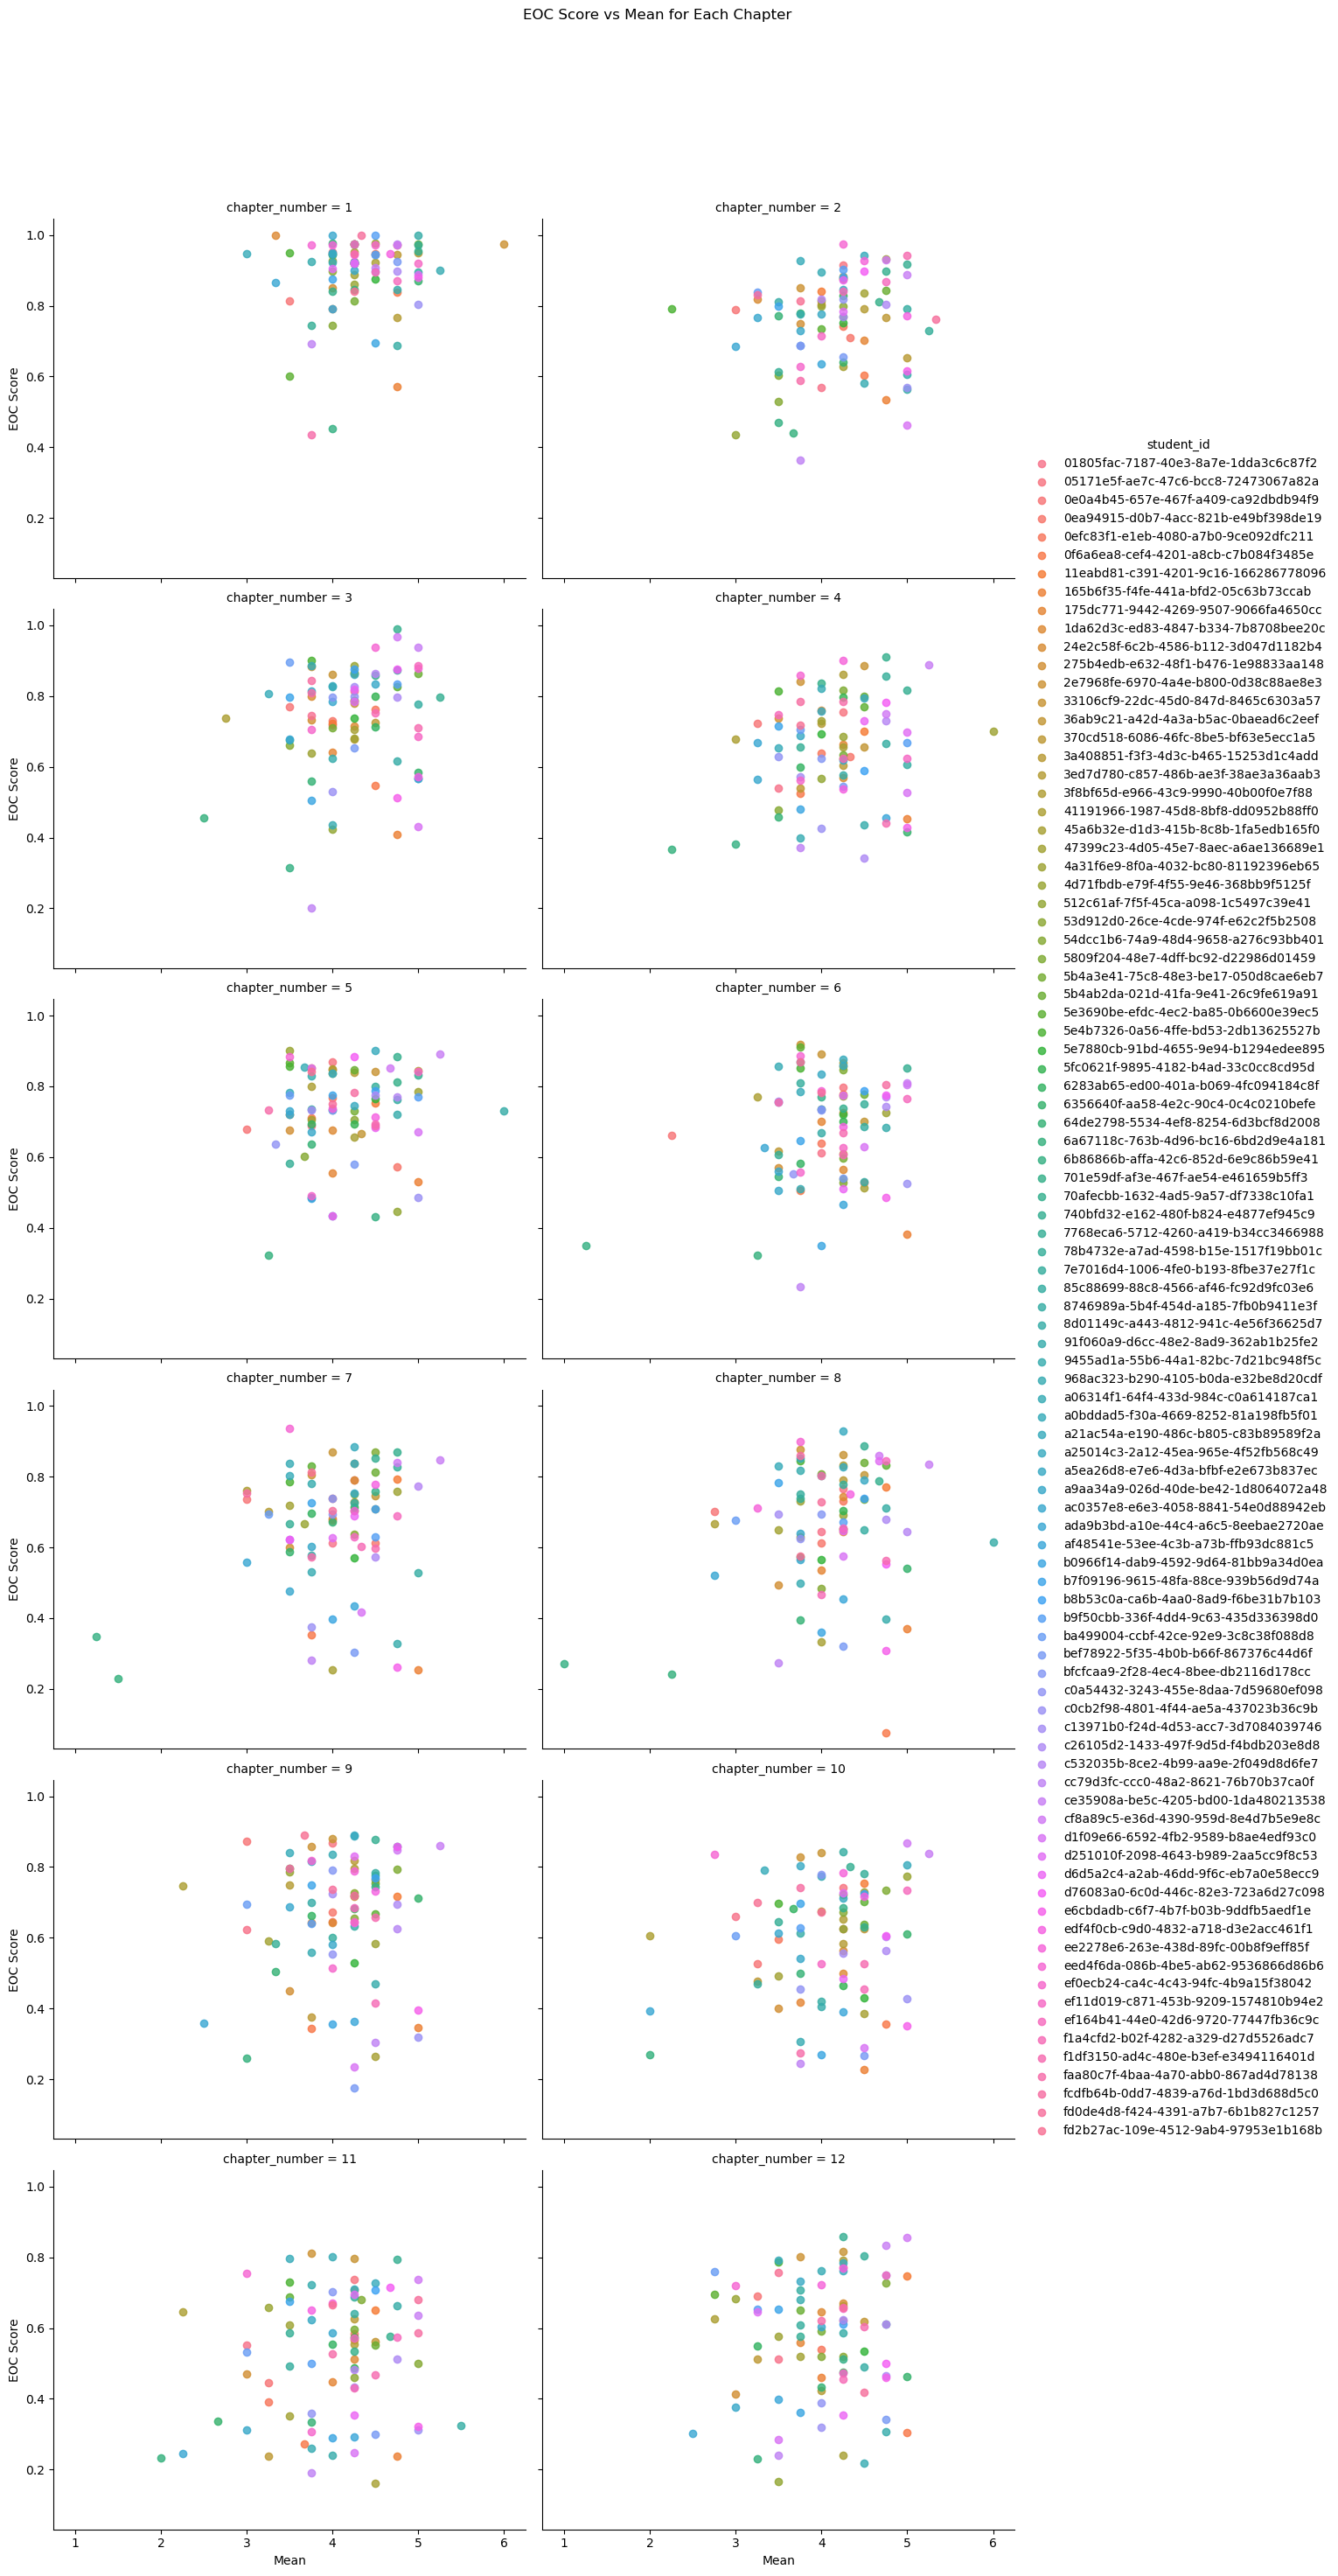

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create separate plots for each chapter
g = sns.lmplot(x='mean', y='EOC', hue='student_id', col='chapter_number', data=final_df, palette='husl', col_wrap=2, height=5, aspect=1.2)

# Set labels and title
g.set_axis_labels("Mean", "EOC Score")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('EOC Score vs Mean for Each Chapter')

# Show the plot
plt.show()

In [40]:
final_df.dropna(inplace=True)
final_df.describe()

,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value,mean,EOC,n_possible,n_correct,n_attempt
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,6.517275,3.233465,4.301579,4.370188,4.544916,4.112537,0.673754,83.626851,55.330701,132.624877
std,3.472499,1.116281,0.998080,0.984153,0.863858,0.594603,0.179240,25.440370,20.051274,294.022110
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.076923,10.000000,1.000000,12.000000
25%,3.000000,2.000000,4.000000,4.000000,4.000000,3.750000,0.569767,66.000000,40.000000,84.000000
50%,7.000000,3.000000,4.000000,5.000000,5.000000,4.250000,0.702703,80.000000,52.000000,106.000000
75%,10.000000,4.000000,5.000000,5.000000,5.000000,4.500000,0.803922,101.000000,73.000000,135.000000
max,12.000000,6.000000,6.000000,6.000000,6.000000,6.000000,1.000000,304.000000,106.000000,8075.000000


In [41]:
final_df.head()

,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value,mean,EOC,n_possible,n_correct,n_attempt
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,1,4.0,5.0,3.0,5.0,4.25,0.921053,38,35,39
1,01805fac-7187-40e3-8a7e-1dda3c6c87f2,2,4.0,4.0,3.0,5.0,4.00,0.570000,100,57,157
2,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3,4.0,5.0,3.0,4.0,4.00,0.718447,103,74,141
3,01805fac-7187-40e3-8a7e-1dda3c6c87f2,4,3.0,4.0,3.0,4.0,3.50,0.539130,116,62,183
4,01805fac-7187-40e3-8a7e-1dda3c6c87f2,5,4.0,4.0,3.0,4.0,3.75,0.688525,61,42,85


C:\Users\jiper\Conda\envs\datafest\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


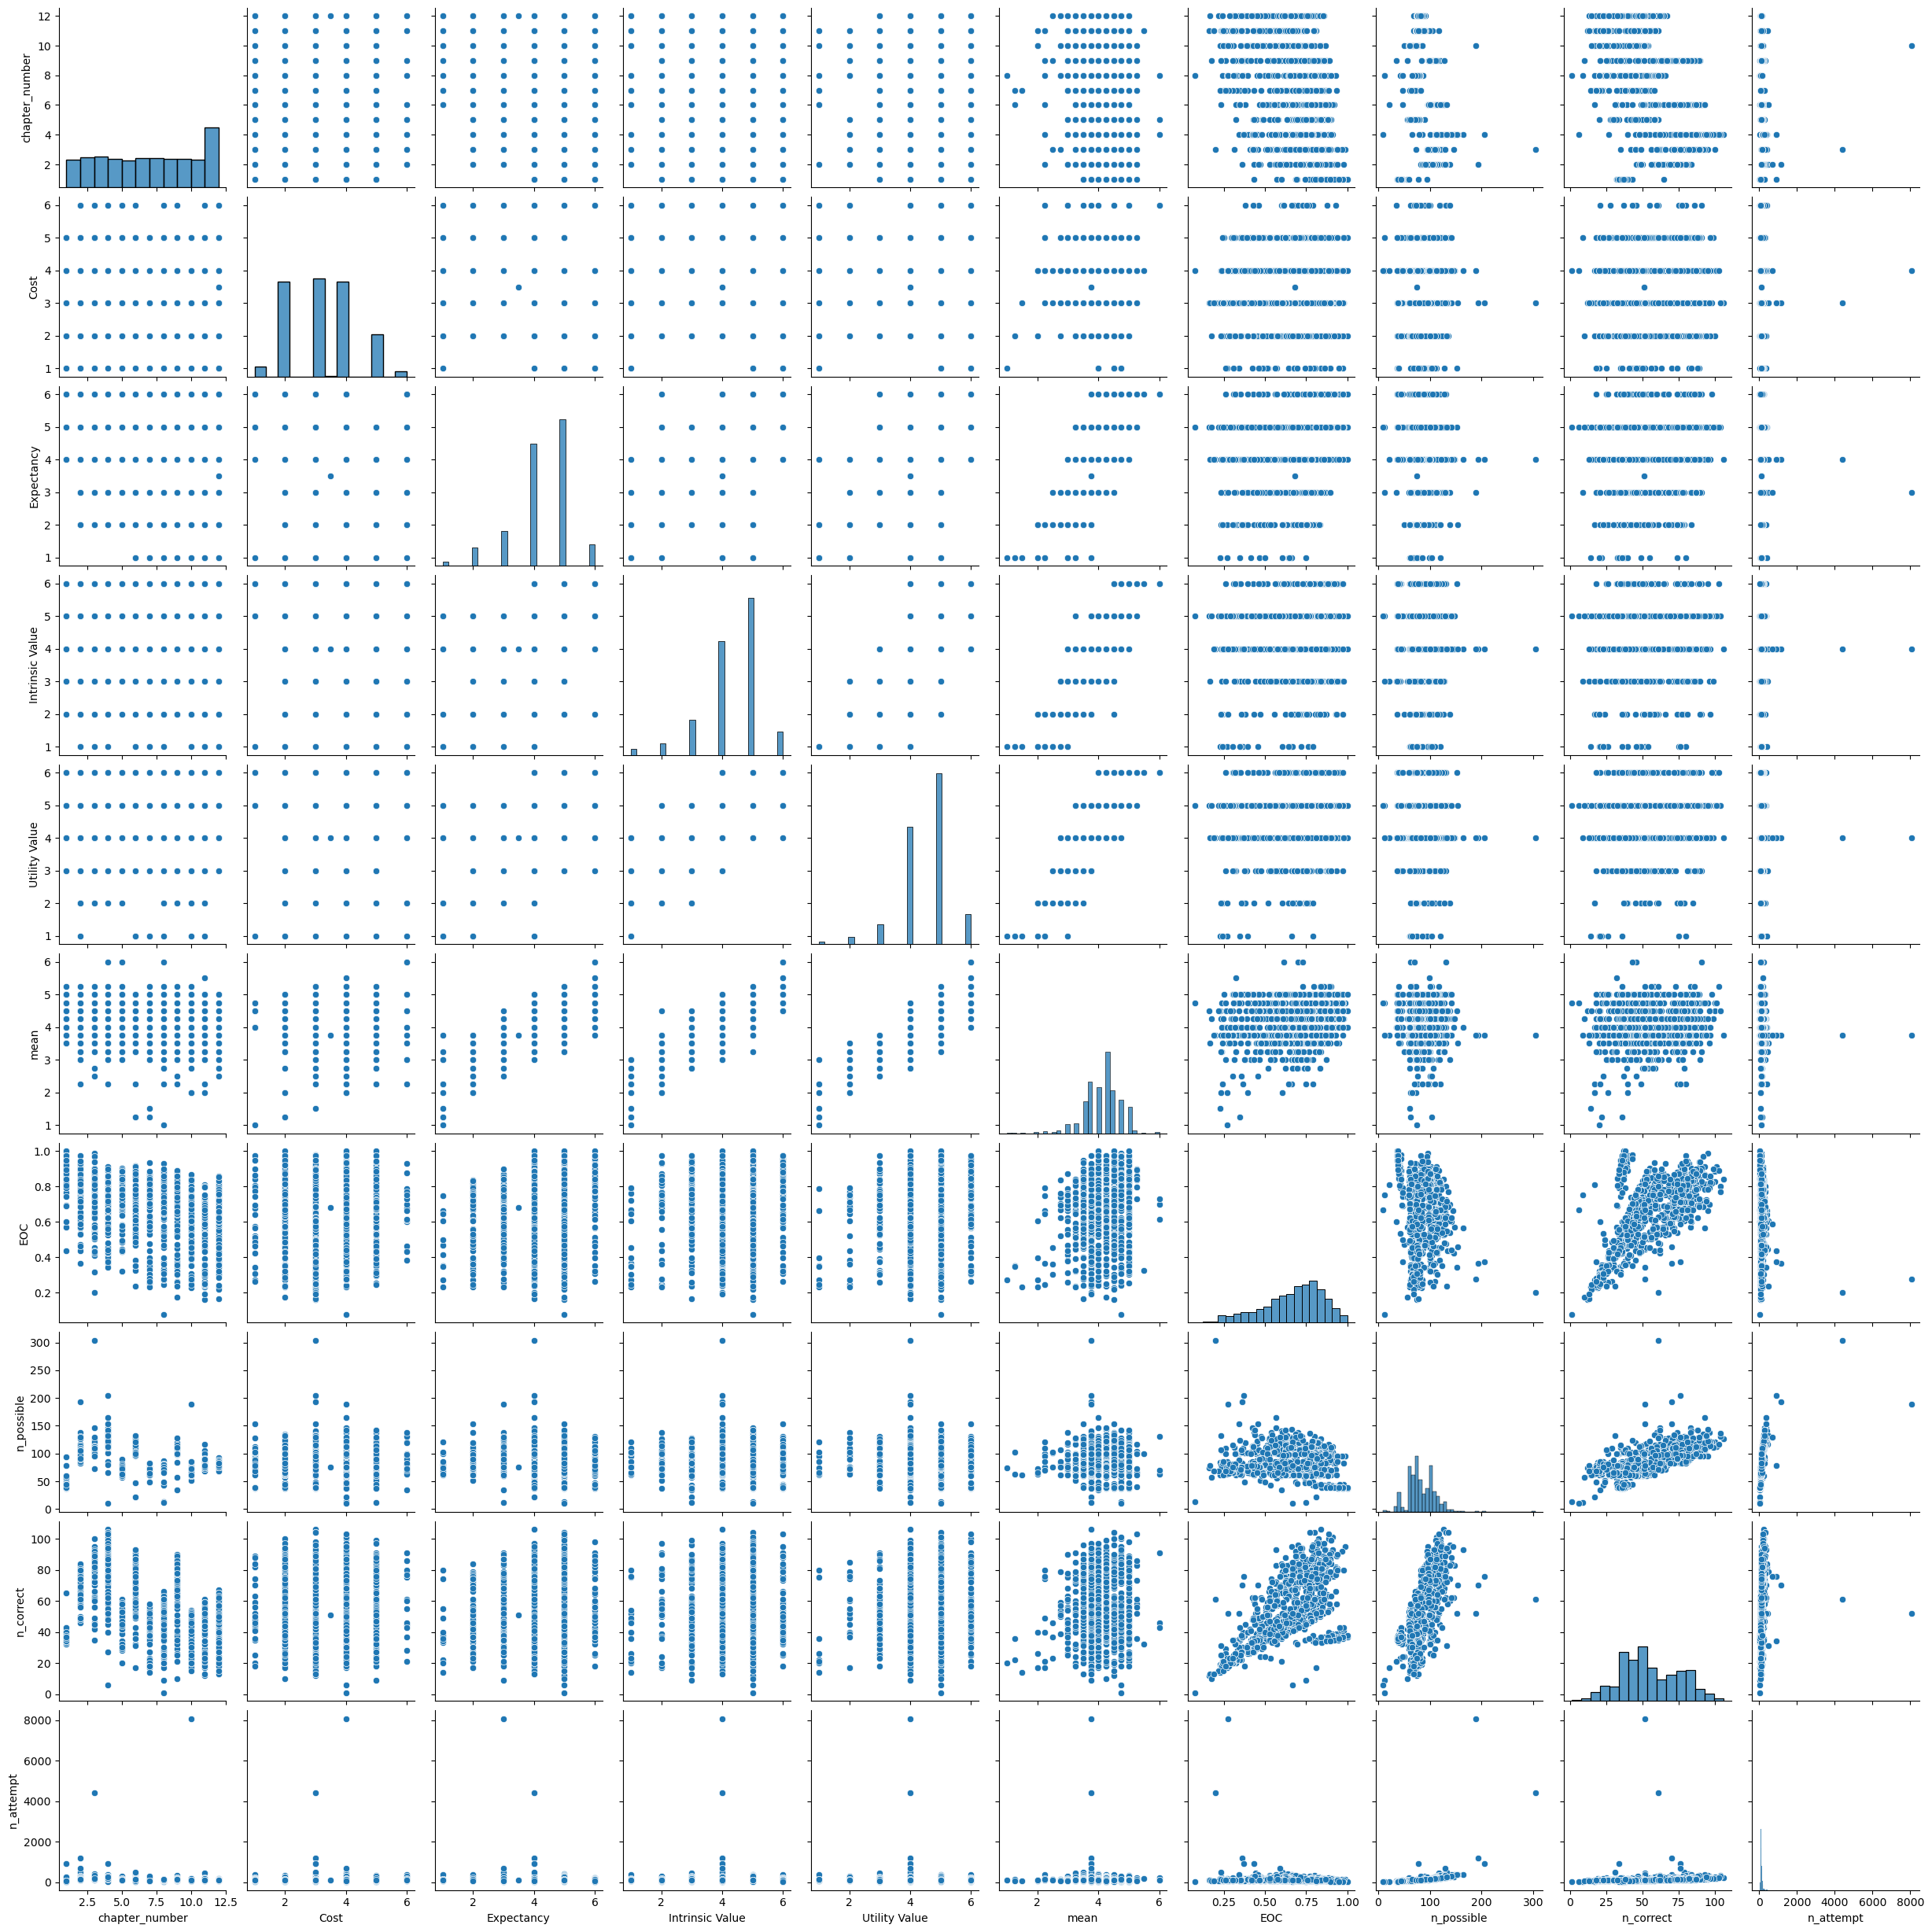

In [42]:
# Create pairplot
sns.pairplot(final_df)

# Show the plot
plt.show()

In [ ]:
final_df.rename(columns={'mean': 'CV'}, inplace=True)


In [43]:
mean_df = final_df.groupby('student_id').mean().reset_index()

# Rename the columns
mean_df.rename(columns={'CV': 'mean_CV', 'EOC': 'mean_EOC'}, inplace=True)

In [48]:
mean_df.head()

,student_id,chapter_number,Cost,Expectancy,Intrinsic Value,Utility Value,mean,mean_EOC,n_possible,n_correct,n_attempt
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,6.500000,3.583333,3.833333,3.333333,3.916667,3.666667,0.638054,81.750000,50.750000,107.666667
1,05171e5f-ae7c-47c6-bcc8-72473067a82a,6.636364,2.727273,4.000000,5.000000,5.090909,4.204545,0.810157,82.090909,66.000000,106.363636
2,0e0a4b45-657e-467f-a409-ca92dbdb94f9,6.500000,4.833333,2.833333,2.166667,2.500000,3.083333,0.700521,92.833333,64.333333,191.333333
3,0ea94915-d0b7-4acc-821b-e49bf398de19,7.200000,4.000000,4.600000,4.000000,4.500000,4.275000,0.648476,80.000000,50.900000,104.900000
4,0efc83f1-e1eb-4080-a7b0-9ce092dfc211,6.500000,4.166667,3.916667,3.916667,4.083333,4.020833,0.678225,80.583333,53.583333,105.583333


In [49]:
# Group by 'student_id' and calculate the mean for 'CV' and 'EOC'
mean_df = mean_df.groupby('student_id')[['mean', 'mean_EOC']].mean().reset_index()

mean_df.head()

,student_id,mean,mean_EOC
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3.666667,0.638054
1,05171e5f-ae7c-47c6-bcc8-72473067a82a,4.204545,0.810157
2,0e0a4b45-657e-467f-a409-ca92dbdb94f9,3.083333,0.700521
3,0ea94915-d0b7-4acc-821b-e49bf398de19,4.275000,0.648476
4,0efc83f1-e1eb-4080-a7b0-9ce092dfc211,4.020833,0.678225


In [51]:
mean_df.rename(columns={'mean': 'CV'}, inplace=True)
mean_df.head()

,student_id,CV,mean_EOC
0,01805fac-7187-40e3-8a7e-1dda3c6c87f2,3.666667,0.638054
1,05171e5f-ae7c-47c6-bcc8-72473067a82a,4.204545,0.810157
2,0e0a4b45-657e-467f-a409-ca92dbdb94f9,3.083333,0.700521
3,0ea94915-d0b7-4acc-821b-e49bf398de19,4.275000,0.648476
4,0efc83f1-e1eb-4080-a7b0-9ce092dfc211,4.020833,0.678225


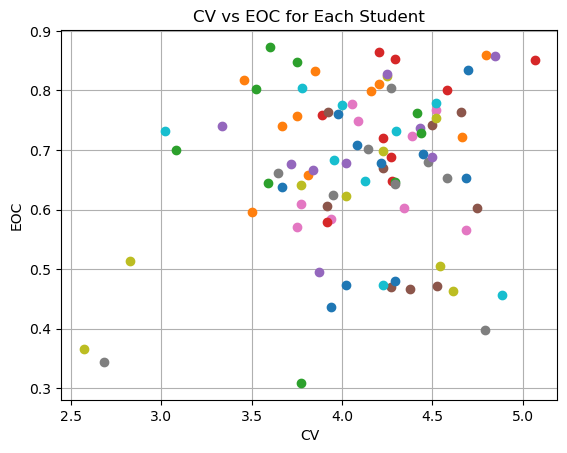

In [56]:
import matplotlib.pyplot as plt

# Get unique student IDs
unique_student_ids = mean_df['student_id'].unique()

# Plot 'CV' against 'EOC' for each student with each student represented by a different color
for student_id in unique_student_ids:
    student_data = mean_df[mean_df['student_id'] == student_id]
    plt.plot(student_data['CV'], student_data['mean_EOC'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('CV')
plt.ylabel('EOC')
plt.title('CV vs EOC for Each Student')
plt.grid(True)

# Show the plot
plt.show()


In [59]:
correlation_coefficient = mean_df['CV'].corr(mean_df['mean_EOC'])
print(correlation_coefficient)

0.18189673037950518
